<a href="https://colab.research.google.com/github/lkarjun/malayalam-language-model/blob/main/malayalam_language_model_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Malayalam Language Model Using Bert LMHEAD

#### Imports

In [3]:
!pip install -qq fastai==2.5.3 transformers tokenizers datasets

     |████████████████████████████████| 311 kB 5.5 MB/s 
     |████████████████████████████████| 1.1 MB 44.8 MB/s 
     |████████████████████████████████| 243 kB 49.6 MB/s 
     |████████████████████████████████| 133 kB 47.9 MB/s 
     |████████████████████████████████| 271 kB 48.1 MB/s 
     |████████████████████████████████| 144 kB 40.9 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 


In [26]:
from fastai.text.all import *
from datasets import load_dataset
from transformers import (BertLMHeadModel,
                          BertConfig,
                          PreTrainedTokenizerFast)

In [6]:
dset = load_dataset("lkarjun/Malayalam-Articles")

Using custom data configuration lkarjun--Malayalam-Articles-d44c52244000c266


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/252M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.3M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/lkarjun--Malayalam-Articles-d44c52244000c266/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

#### Load datasets

In [174]:
train = dset['train'].to_pandas()[:1000]

In [175]:
train.dropna(inplace=True)

### Tokenizer

In [17]:
pre_tokenizer = PreTrainedTokenizerFast.from_pretrained("lkarjun/malayalam-language-model")

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

In [146]:
def tokenize(text):
  assert type(text) == str, "check the input type"
  toks = pre_tokenizer.tokenize(text)
  toks = ['[CLS]'] + toks + ['[SEP]']
  toks = pre_tokenizer.convert_tokens_to_ids(toks)
  return tensor(toks)

In [147]:
class MlTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

### Model Config

Default Bert Config

( vocab_size = 30522 hidden_size = 768 num_hidden_layers = 12 num_attention_heads = 12 intermediate_size = 3072 hidden_act = 'gelu' hidden_dropout_prob = 0.1 attention_probs_dropout_prob = 0.1 max_position_embeddings = 512 type_vocab_size = 2 initializer_range = 0.02 layer_norm_eps = 1e-12 pad_token_id = 0 position_embedding_type = 'absolute'use_cache = Truec lassifier_dropout = None **kwargs )

In [41]:
config = BertConfig(num_attention_heads = 8, 
                    intermediate_size = 2072, 
                    hidden_size = 568,
                    vocab_size = pre_tokenizer.vocab_size,
                    pad_token_id = pre_tokenizer.pad_token_id, is_decoder=True, 
                    name_or_path = "lkarjun/malayalam-language-model")

In [43]:
ml_bert_model = BertLMHeadModel(config)

### Dataloaders

In [176]:
tokenized = [tokenize(t) for t in progress_bar(train['content'])]

In [180]:
splits = RandomSplitter(.2, 7)(tokenized)
splits

((#797) [455,617,631,628,108,96,854,947,440,419...],
 (#199) [843,493,393,713,391,671,743,621,396,47...])

In [182]:
tls = TfmdLists(tokenized, 
                MlTokenizer(pre_tokenizer), 
                dl_type=LMDataLoader,
                splits = splits, 
                verbose=True)

Setting up Pipeline: MlTokenizer


In [184]:
dls = tls.dataloaders(bs = 5, seq_len=80)

In [185]:
dls.show_batch(max_n = 2)

,text,text_
0,[CLS] മരണത്തിലേക്കു ##ള്ള വഴി കഥ 1 വധശിക്ഷ രാഷ്‌ട്രപതി ദയാഹ ##ർജി തള്ളി!. ഇതായിരുന്നു അവസാനത്തെ കച്ചി ##ത്തുരു ##മ്പ്. ഇനി ഒന്നും ചെയ്യാൻ ഇല്ല. പ്രതീക്ഷയുടെ എല്ലാ വാതിലുകളും അടഞ്ഞു. ജയിലിലെ സിമ ##െന്റ് തറയിൽ കിടന്നു കൊണ്ട് അയാൾ ശ്വാസം വലിച്ചു വിട്ടു. ഈ ശ്വാസ ##ത്തിനും അവസാനത്തെ ശ്വാസ ##ത്തിനും ഇടയിൽ ഇനി ഈ രാത്രി മാത്രം ബാക്കി. മനസ്സിൽ ഭയം കുമിഞ്ഞു കൂടുന്നു. അയാൾ ജയില ##ഴി ##കളിലൂടെ വിത ##ൂര ##തയിലേക്കു നോക്കി. നിലാവ ##ിൽ അവ്യക്തമായി മരങ്ങൾ കാണാം. പിന്നെ മേഘ ##ങ്ങളും അതിന്റെ ഇടയിൽ പൂർണ്ണ ##ചന്ദ്ര,മരണത്തിലേക്കു ##ള്ള വഴി കഥ 1 വധശിക്ഷ രാഷ്‌ട്രപതി ദയാഹ ##ർജി തള്ളി!. ഇതായിരുന്നു അവസാനത്തെ കച്ചി ##ത്തുരു ##മ്പ്. ഇനി ഒന്നും ചെയ്യാൻ ഇല്ല. പ്രതീക്ഷയുടെ എല്ലാ വാതിലുകളും അടഞ്ഞു. ജയിലിലെ സിമ ##െന്റ് തറയിൽ കിടന്നു കൊണ്ട് അയാൾ ശ്വാസം വലിച്ചു വിട്ടു. ഈ ശ്വാസ ##ത്തിനും അവസാനത്തെ ശ്വാസ ##ത്തിനും ഇടയിൽ ഇനി ഈ രാത്രി മാത്രം ബാക്കി. മനസ്സിൽ ഭയം കുമിഞ്ഞു കൂടുന്നു. അയാൾ ജയില ##ഴി ##കളിലൂടെ വിത ##ൂര ##തയിലേക്കു നോക്കി. നിലാവ ##ിൽ അവ്യക്തമായി മരങ്ങൾ കാണാം. പിന്നെ മേഘ ##ങ്ങളും അതിന്റെ ഇടയിൽ പൂർണ്ണ ##ചന്ദ്ര ##നും
1,"##വീര ##ന്. കാട്ടാന മരത്ത ##ൊലി, മരച്ചില്ല, പച്ച ഇലകൾ, ഇല്ല ##ി, പുല്ല് ##‌ എന്നിവയൊക്കെ തിന്നു ##മ്പോ ##ൾ നാട്ടാന പനം ##പട്ട, തെങ്ങോല, കൈത, പന ##മരം, ചോള ##ത്തണ്ട ##്‌, കരിമ്പ് ##‌, പഴം എന്നിവയൊക്കെ ഭക്ഷണമാക്കുന്ന ##ു. പണമ ##ുള്ള ഉടമസ്ഥർ അരി, നെല്ല് ##‌, മുതിര, റാഗി, ഗോതമ്പ് ##‌ എന്നിവ പാകപ്പെടുത്തി ആന ##ക്കു കൊടുക്കാറുണ്ട്. അങ്ങനെ അകത്തു ##ചെല്ല ##ുന്ന ഭക്ഷണത്തിന്റെ നാൽപതു ശതമാനം മാത്രമാണ് കുടലിൽ ആഗിരണം ചെയ്യ ##പ്പട ##ുന്നത്. ബാക്കി,","##ന്. കാട്ടാന മരത്ത ##ൊലി, മരച്ചില്ല, പച്ച ഇലകൾ, ഇല്ല ##ി, പുല്ല് ##‌ എന്നിവയൊക്കെ തിന്നു ##മ്പോ ##ൾ നാട്ടാന പനം ##പട്ട, തെങ്ങോല, കൈത, പന ##മരം, ചോള ##ത്തണ്ട ##്‌, കരിമ്പ് ##‌, പഴം എന്നിവയൊക്കെ ഭക്ഷണമാക്കുന്ന ##ു. പണമ ##ുള്ള ഉടമസ്ഥർ അരി, നെല്ല് ##‌, മുതിര, റാഗി, ഗോതമ്പ് ##‌ എന്നിവ പാകപ്പെടുത്തി ആന ##ക്കു കൊടുക്കാറുണ്ട്. അങ്ങനെ അകത്തു ##ചെല്ല ##ുന്ന ഭക്ഷണത്തിന്റെ നാൽപതു ശതമാനം മാത്രമാണ് കുടലിൽ ആഗിരണം ചെയ്യ ##പ്പട ##ുന്നത്. ബാക്കി, എര"


### Training

In [186]:
class FixOUTPUT(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [187]:
learn = Learner(dls, 
                ml_bert_model, 
                loss_func=CrossEntropyLossFlat(),
                cbs=[FixOUTPUT],
                metrics=Perplexity()).to_fp16()

SuggestedLRs(valley=0.00019054606673307717)

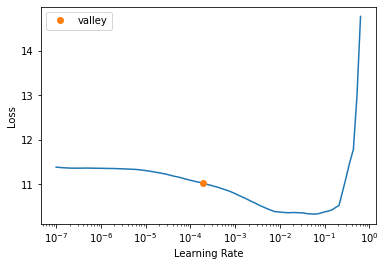

In [157]:
learn.lr_find()

In [ ]:
learn.fit(5, lr=1e-4)